# Spike centered plot
based on conversations with Robert and Ted Carnevale.


In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from neuron import h
h.load_file("stdrun.hoc")
sys.path.insert(1, "./utils/")
import HH, Stimuli
import matplotlib as mpl
import random

## Hyperparameters

In [2]:
stim_types = ['base','lw','lt','lwlt','burst']
figures_dir = './figures/'

sim_duration = 100000

e_times = Stimuli.poisson_process_duration(5, sim_duration)
i_times = Stimuli.poisson_process_duration(15, sim_duration)

stim_scaffold = {
    'base': {
        'ex': Stimuli.PoissonStim(
            'ex_base', 'ex_base',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_base', 'in_base',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=6,
            seed='na'
        )
    },
    'lw': {
        'ex': Stimuli.PoissonStim(
            'ex_lw', 'ex_lw',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=2,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lw', 'in_lw',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=6,
            seed='na'
        )
    },
    'lt': {
        'ex': Stimuli.PoissonStim(
            'ex_lt', 'ex_lt',
            interval=5,
            rev_potential=0,
            weight=0.0002,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lt', 'in_lt',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=40,
            seed='na'
        )
    },
    'lwlt': {
        'ex': Stimuli.PoissonStim(
            'ex_lwlt', 'ex_lwlt',
            interval=5,
            rev_potential=0,
            weight=0.00015,
            tau=10,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_lwlt', 'in_lwlt',
            interval=15,
            rev_potential=-80,
            weight=0.0002,
            tau=40,
            seed='na'
        )
    },
    'burst': {
        'ex': Stimuli.PoissonStim(
            'ex_burst', 'ex_burst',
            interval=5,
            rev_potential=0,
            weight=0.0001,
            tau=40,
            seed='na'
        ),
        'in': Stimuli.PoissonStim(
            'in_burst', 'in_burst',
            interval=15,
            rev_potential=-80,
            weight=0.0005,
            tau=20,
            seed='na'
        )
    }
}

for stim_type in stim_scaffold:
    stim_scaffold[stim_type]['ex'].stim_times = e_times
    stim_scaffold[stim_type]['in'].stim_times = i_times

In [3]:
sims = {stim_type:HH.HH() for stim_type in stim_types}

for stim_type in stim_types:
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['ex'])
    sims[stim_type].add_custom_stimulus(stim_scaffold[stim_type]['in'])
    sims[stim_type].run_simulation(sim_duration)

In [4]:
df_base = np.array([sims['base']._v, sims['base']._m, sims['base']._n, sims['base']._h]).T
df_hw = np.array([sims['lw']._v, sims['lw']._m, sims['lw']._n, sims['lw']._h]).T
df_lt = np.array([sims['lt']._v, sims['lt']._m, sims['lt']._n, sims['lt']._h]).T
df_hwlt = np.array([sims['lwlt']._v, sims['lwlt']._m, sims['lwlt']._n, sims['lwlt']._h]).T
df_burst = np.array([sims['burst']._v, sims['burst']._m, sims['burst']._n, sims['burst']._h]).T

## action potential variance

In [5]:
def get_spike_windows(df, spikes, prespike_window=100, postspike_window=100):
    spike_windows = []
    for spike in spikes[10:-10]:
        start = int((spike-prespike_window)*40)
        stop = int((spike+postspike_window)*40)
        spike_windows.append((df[start:stop, :]))
    spike_windows = np.stack(spike_windows)
    return spike_windows
spike_windows = get_spike_windows(df_base, np.array(sims['base'].spike_times))
spike_windows_hw = get_spike_windows(df_hw, np.array(sims['lw'].spike_times))
spike_windows_lt = get_spike_windows(df_lt, np.array(sims['lt'].spike_times))
spike_windows_hwlt = get_spike_windows(df_hwlt, np.array(sims['lwlt'].spike_times))
spike_windows_burst = get_spike_windows(df_burst, np.array(sims['burst'].spike_times))

print(len(sims['base'].spike_times), spike_windows.shape)
print(len(sims['lw'].spike_times), spike_windows_hw.shape)
print(len(sims['lt'].spike_times), spike_windows_lt.shape)
print(len(sims['lwlt'].spike_times), spike_windows_hwlt.shape)
print(len(sims['burst'].spike_times), spike_windows_burst.shape)

2190 (2170, 8000, 4)
1461 (1441, 8000, 4)
1838 (1818, 8000, 4)
2347 (2327, 8000, 4)
2985 (2965, 8000, 4)


In [6]:
# normalize
def normalize_vec(vec, axis=1):
    vec = vec - np.min(vec)
    vec = vec / np.max(vec)
    return vec

def normalize_df(spike_windows):
    return np.array(
        [normalize_vec(spike_windows[:,:,0]),
        normalize_vec(spike_windows[:,:,1]),
        normalize_vec(spike_windows[:,:,2]),
        normalize_vec(spike_windows[:,:,3])]
    )

spike_windows_norm = normalize_df(spike_windows)
spike_windows_norm_hw = normalize_df(spike_windows_hw)
spike_windows_norm_lt = normalize_df(spike_windows_lt)
spike_windows_norm_hwlt = normalize_df(spike_windows_hwlt)
spike_windows_norm_burst = normalize_df(spike_windows_burst)

In [7]:
spike_windows_vars = np.var(spike_windows_norm, axis=(0,1))
spike_windows_vars_hw = np.var(spike_windows_norm_hw, axis=(0,1))
spike_windows_vars_lt = np.var(spike_windows_norm_lt, axis=(0,1))
spike_windows_vars_hwlt = np.var(spike_windows_norm_hwlt, axis=(0,1))
spike_windows_vars_burst = np.var(spike_windows_norm_burst, axis=(0,1))

In [8]:
def state_variable_vars(spike_windows_norm):
    v_vars = np.var(spike_windows_norm[0,:], axis=(0))
    h_vars = np.var(spike_windows_norm[1,:], axis=(0))
    n_vars = np.var(spike_windows_norm[2,:], axis=(0))
    m_vars = np.var(spike_windows_norm[3,:], axis=(0))
    return v_vars, h_vars, n_vars, m_vars
v_vars, h_vars, n_vars, m_vars = state_variable_vars(spike_windows_norm)
v_vars_hw, h_vars_hw, n_vars_hw, m_vars_hw = state_variable_vars(spike_windows_norm_hw)
v_vars_lt, h_vars_lt, n_vars_lt, m_vars_lt = state_variable_vars(spike_windows_norm_lt)
v_vars_hwlt, h_vars_hwlt, n_vars_hwlt, m_vars_hwlt = state_variable_vars(spike_windows_norm_hwlt)
v_vars_burst, h_vars_burst, n_vars_burst, m_vars_burst = state_variable_vars(spike_windows_norm_burst)

In [9]:
def spike_center_plot(spike_windows, v_vars, h_vars, n_vars, m_vars, prespike_window=100, postspike_window=100, savefile=None):
    fig, ax = plt.subplots(figsize=(6.5,3))
    
    _t = np.arange(0, prespike_window+postspike_window, 1/40)
    
    num_traces = min(1000, spike_windows.shape[0])

    for i in range(num_traces):
        ax.plot(_t-prespike_window, spike_windows[i,:,0], c='black', alpha=0.01)

    ax2=ax.twinx()
    ax2.plot(_t-prespike_window, v_vars, c='purple')
    ax2.plot(_t-prespike_window, h_vars, c='red')
    ax2.plot(_t-prespike_window, n_vars, c='blue')
    ax2.plot(_t-prespike_window, m_vars, c='green')

    ax.set_ylabel('Membrane voltage (mV)')
    ax2.set_ylabel('Variance ofnormalized\nstate variables', color='red')
    ax2_yticks=np.arange(0,16,2)/100
    ax2.set_yticks(ax2_yticks)
    ax2.set_yticklabels(ax2_yticks, color='red')
    ax.set_xlabel('time (ms)')
    ax.set_xlim(0-prespike_window, postspike_window)
    
    ax2.legend(['Vm','h','n','m'])
    
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    if savefile:
        plt.savefig(savefile, format='svg')

    plt.show()

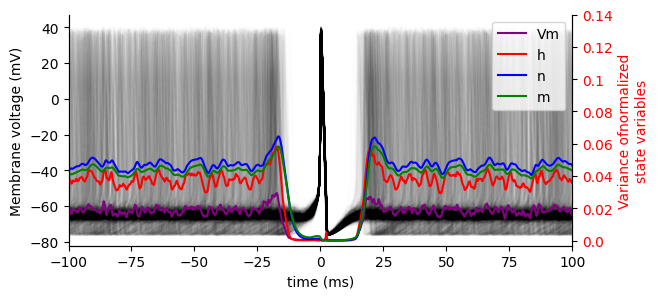

In [10]:
spike_center_plot(spike_windows, v_vars=v_vars, h_vars=h_vars, n_vars=n_vars, m_vars=m_vars, savefile=f'{figures_dir}spike_centered_base.svg')

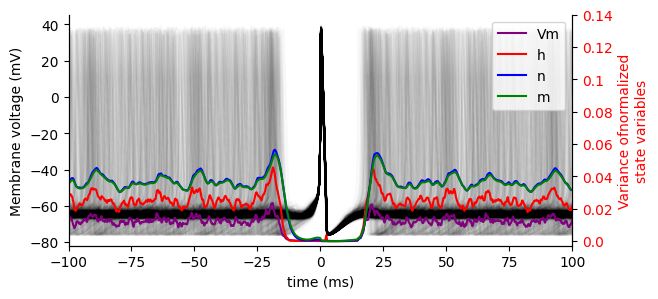

In [11]:
spike_center_plot(spike_windows_hw, v_vars_hw, h_vars_hw, n_vars_hw, m_vars_hw)

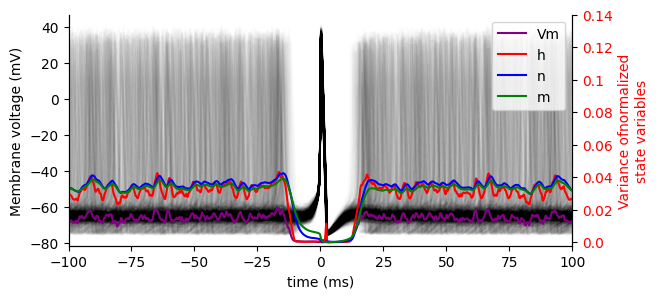

In [12]:
spike_center_plot(spike_windows_lt, v_vars_lt, h_vars_lt, n_vars_lt, m_vars_lt)

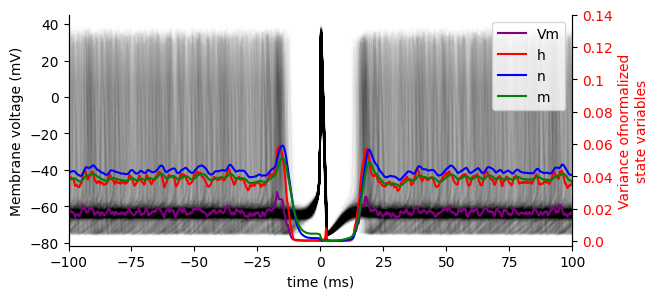

In [13]:
spike_center_plot(spike_windows_hwlt, v_vars_hwlt, h_vars_hwlt, n_vars_hwlt, m_vars_hwlt)

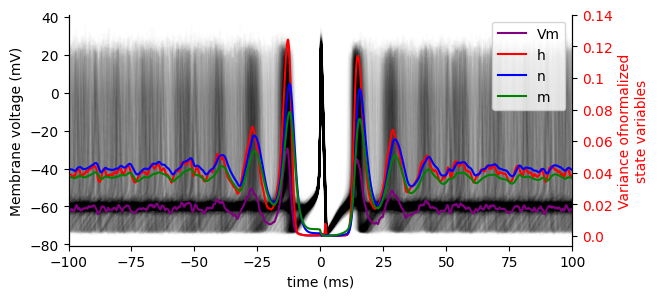

In [14]:
spike_center_plot(spike_windows_burst, v_vars_burst, h_vars_burst, n_vars_burst, m_vars_burst, savefile=f'{figures_dir}spike_centered_burst.svg')

## get the baseline state variable variance

In [19]:
print('base v var:', np.var(normalize_vec(df_base[:,0]), axis=(0)))
print('lw v var:', np.var(normalize_vec(df_hw[:,0]), axis=(0)))
print('lt v var:', np.var(normalize_vec(df_lt[:,0]), axis=(0)))
print('lwlt v var:', np.var(normalize_vec(df_hwlt[:,0]), axis=(0)))
print('burst v var:', np.var(normalize_vec(df_burst[:,0]), axis=(0)))

base v var: 0.01843158685515861
lw v var: 0.012469327786090357
lt v var: 0.0144369245220828
lwlt v var: 0.01778921915495492
burst v var: 0.017436031817629722


In [20]:
print('min v var base:', np.min(v_vars))
print('min v var lw:', np.min(v_vars_hw))
print('min v var lt:', np.min(v_vars_lt))
print('min v var lwlt:', np.min(v_vars_hwlt))
print('min v var burst:', np.min(v_vars_burst))

min v var base: 3.920207811420396e-06
min v var lw: 2.467270889633908e-06
min v var lt: 1.726862665821252e-05
min v var lwlt: 1.079748896623115e-05
min v var burst: 1.8014856373596125e-05


In [21]:
print('percent v var base:', 
      np.min(v_vars) / np.var(normalize_vec(df_base[:,0]), axis=(0))*100)
print('percent v var lw:', 
      np.min(v_vars_hw) / np.var(normalize_vec(df_hw[:,0]), axis=(0))*100)
print('percent v var lt:', 
      np.min(v_vars_lt) / np.var(normalize_vec(df_lt[:,0]), axis=(0))*100)
print('percent v var lwlt:', 
      np.min(v_vars_hwlt) / np.var(normalize_vec(df_hwlt[:,0]), axis=(0))*100)
print('percent v var burst:', 
      np.min(v_vars_burst) / np.var(normalize_vec(df_burst[:,0]), axis=(0))*100)


percent v var base: 0.02126896529434313
percent v var lw: 0.01978671931606586
percent v var lt: 0.1196143031142009
percent v var lwlt: 0.06069681233436079
percent v var burst: 0.10331970348540628
